# "Global Bouguer" using global SH models and SHTOOLS

This notebook aims at computing a *topography-reduced gravity disturbance* (or *complete Bouguer disturbance*, or *NETC disturbance*) starting from the spherical harmonics coefficients of a global gravity field model and a synthetic model of the effect of topography, ice, and water. The code relies *heavily* on the Python components (functions and classes) of [SHTOOLS](https://shtools.oca.eu/shtools/public/) (Wieczorek and Meschede, 2018, [doi:10.1029/2018GC007529](https://doi.org/10.1029/2018GC007529)).

It was set up to try SHTOOLS out of curiosity and, after a bit of trial and error, successfully compute a Bouguer disturbance, which *should* be a trivial task. This means obtaining the following, Eq. 33 of [STR09/02](https://doi.org/10.2312/GFZ.b103-0902-26):

$ \delta g_{tr} (h, \lambda, \phi) =
\left | \nabla \left[ W (h, \lambda, \phi) - V_t (h, \lambda, \phi) \right ] \right |
-
\left | \nabla U (h, \phi) \right |
$

where the sequence of differences and norms is, unsurprisingly, of utmost importance.

Since this example is carried out at relatively low degrees, way less than the complete spectral content of the models involved, a re-implementation of the gentle-cut truncation proposed by [Barthelmes (2008)](http://icgem.gfz-potsdam.de/gentlecut_engl.pdf) is included.
It is successful in avoiding sidelobes/ringing.

This notebook was set up with the following gravity models in mind, downloaded in the gfc format from [ICGEM](http://icgem.gfz-potsdam.de/home):

* Input global gravity model: **XGM2019e**, Zingerle, P., Pail, R., Gruber, T., Oikonomidou, X. (2019): The experimental gravity field model XGM2019e. *GFZ Data Services*. [doi:10.5880/ICGEM.2019.007](http://doi.org/10.5880/ICGEM.2019.007).

* Topographic effect model: **dV_ELL_Earth2014**, Rexer, M., Hirt, C., Claessens, S., Tenzer, R. (2016): Layer-based modelling of the Earth's gravitational potential up to 10km-scale in spherical harmonics in spherical and ellipsoidal approximation. *Surveys in Geophysics*. [doi:10.1007/s10712-016-9382-2](https://doi.org/10.1007/s10712-016-9382-2).

When run in Binder, these two models are downloaded and unzipped after the container is built, using the 'binder/PostBuild' script provided this git repository.
If run locally, 'binder/PostBuild' must be run beforehand and the downloaded file moved accordingly (or the read_icgem_gfc edited with the correct path).
The code below should work with any other combination of models with a maximum SH degree equal or greater than the maximum SH degree of the required grid. Otherwise, zero-padding the missing high degrees is needed.
Note that the topographic effect model does not include the normal potential.

#### ⚠️ Disclaimer
Keep in mind that this example deals with computing a *topography-reduced gravity disturbance*, as described in Eq. 33 of [STR09/02](https://doi.org/10.2312/GFZ.b103-0902-26), using SHTOOLS and gfc files downloaded from ICGEM. 
Its aim is keeping formal consistency in the computation - a trivial task, albeit prone to errors.
Apart from this, for this purposes, any other issue was deemed of secondary importance (to a reasonable extent). Thus I must warn against using the 'Bouguer disturbance' here obtained in any application.

There are some maps of the tensor (2nd derivative of the topography-reduced disturbing potential), at the notebook far end.
They were done out of curiosity, the same disclaimer applies.


In [1]:
%matplotlib inline
import numpy as np
import pyshtools
import shtaper
import copy
import cartopy.crs as ccrs

Set the grid step, the consequent maximum SH degree to compute, and the observation height (over the WGS84 ellipsoid).

In [2]:
grid_step = 0.25
SH_lmax_grid = int(90/grid_step - 1)  # max degree to get a grid_step spaced grid

obs_height = 20e3  # m
obs_a = pyshtools.constant.a_wgs84.value + obs_height

## Read the input models (gfc files)
To keep this example lean, we read the coefficients in the gfc files up to the maximum SH degree of the required grid.

Note that we are providing the angular velocity of rotation ($\omega$) for the GGM only - it is set to zero for the terrain effect model. Failure to do so results in the centrifugal potential (absent from the TC model) being incorrectly removed.

Also note that the terrain-refined disturbing potential and gravity disturbance obtained in this notebook **are by no means rigorous** in respect to the computation of the terrain correction.
As the Authors of Earth2014 (cited above) warn in the header of `dV_ELL_Earth2014.gfc`, the model:
> "always should be evaluated to its maximum degree ($N_{max}=2190$), since the last 30 coefficients account for the ellipsoidal shape of Earth. Neglecting this "tail" of coefficients or truncating the model at lower degrees during SHS will result in severe error patterns, especially at high latitudes."

See also: Rexer, M., Hirt, C., Claessens, S., Tenzer, R. (2016) "Layer-based modelling of the Earth's gravitational potential up to 10km-scale in spherical harmonics in spherical and ellipsoidal approximation", *Surveys in Geophysics*, [doi:10.1007/s10712-016-9382-2](https://doi.org/10.1007/s10712-016-9382-2).

*Variable naming*: `GGM` refers to the global gravity model, `GTM` refers to the global topographic effect model, `Tbg` to the disturbing potential corrected for the topographic masses.


In [3]:
GGM_filename = 'XGM2019.gfc'
GTM_filename = 'dV_ELL_Earth2014.gfc'

In [4]:
GGM_cilm, GGM_gm, GGM_r0 = \
    pyshtools.shio.read_icgem_gfc(GGM_filename, lmax=SH_lmax_grid)
GTM_cilm, GTM_gm, GTM_r0 = \
    pyshtools.shio.read_icgem_gfc(GTM_filename, lmax=SH_lmax_grid)

From $C_{l,m}$ arrays to the `pyshtools.SHGravCoeffs` class, using the `from_array` constructor method:

In [5]:
GGM_coeffs = pyshtools.SHGravCoeffs.from_array(
    GGM_cilm, GGM_gm, GGM_r0,
    omega=pyshtools.constant.omega_wgs84.value,
    lmax=SH_lmax_grid)
GTM_coeffs = pyshtools.SHGravCoeffs.from_array(
    GTM_cilm, GTM_gm, GTM_r0,
    omega=0,
    lmax=SH_lmax_grid)

Note that the GGM and the topography effect model may not share the same reference ($GM$ and $r_0$).


In [6]:
print(' *** Gravity model properties *** ')
GGM_coeffs.info()
print('\n *** Terrain effect model properties ***')
GTM_coeffs.info()

 *** Gravity model properties *** 
kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 359
GM (m3 / s2) = 398600441500000.0
r0 (m) = 6378136.3
Omega (rad / s) = 7.292115e-05
errors are set: False
header = None

 *** Terrain effect model properties ***
kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 359
GM (m3 / s2) = 398600500000000.0
r0 (m) = 6378137.0
Omega (rad / s) = 0
errors are set: False
header = None


Therefore, we re-reference both to the same, using $GM$ from the gravity model (`GGM_gm`) and a new reference radius $r_0$ (`new_ref_r0`).

The upward continuation to this new value assumes this radius lies outside any masses (documentation: see [1](https://shtools.oca.eu/shtools/public/python-shgravcoeffs.html), [2](https://github.com/SHTOOLS/SHTOOLS/blob/6fdd2f420ceb61b5fe482793db1f6762f1d88ddb/pyshtools/shclasses/shcoeffsgrid.py))

In [7]:
new_ref_r0 = pyshtools.constant.a_wgs84.value + 8e3 # outside of masses!

GGM_coeffs = GGM_coeffs.change_ref(gm=GGM_gm, r0=new_ref_r0)
GTM_coeffs = GTM_coeffs.change_ref(gm=GGM_gm, r0=new_ref_r0)

## Apply a 'gentle-cut' low pass filter
Both the global gravity model and the terrain correction model have spectral contents at higher degrees than the grid we are plotting here. Boxcar truncation results in sidelobes (aka ringing), see [*Low Pass Filtering of Gravity Field Models by Gently Cutting the Spherical Harmonic Coefficients of Higher Degrees*, by Franz Barthelmes](http://icgem.gfz-potsdam.de/gentlecut_engl.pdf).

The `shtaper` module provides a function with the same name ([see shtaper.py in the repository](https://github.com/apasto/ggm_bg_maps_binder/blob/master/shtaper.py)). It consists of an implementation of the gentle-cut function proposed by Barthelmes, providing the necessary degree-wise tapered weights.
This should be identical (hopefully) to the "Low-pass filering by (gently) truncating the model" that the ICGEM [Calculation Service](http://icgem.gfz-potsdam.de/calcgrid) provides.


In [8]:
LP_weights = \
    shtaper.taper_weights(l_start=300, l_stop=SH_lmax_grid, taper="gentle")

# copy a new instance of the SH coefficients classes
# then multiply their SH coefficients by the tapered weights

GGM_coeffs_LP = copy.deepcopy(GGM_coeffs)
GGM_coeffs_LP.coeffs = np.multiply(GGM_coeffs_LP.coeffs, LP_weights)

GTM_coeffs_LP = copy.deepcopy(GTM_coeffs)
GTM_coeffs_LP.coeffs = np.multiply(GTM_coeffs_LP.coeffs, LP_weights)

Expand the GGM and the terrain correction to grids.

In [9]:
GGM_grid = pyshtools.SHGravCoeffs.expand(
    GGM_coeffs_LP,
    a=obs_a, f=pyshtools.constant.f_wgs84.value,
    extend=False, lmax=SH_lmax_grid, normal_gravity=True)
GGM_grid_gd = pyshtools.SHGrid.from_array(GGM_grid.total.data*1e5)  # to mGal
GTM_grid = pyshtools.SHGravCoeffs.expand(
    GTM_coeffs_LP,
    a=obs_a, f=pyshtools.constant.f_wgs84.value,
    extend=False, lmax=SH_lmax_grid, normal_gravity=False)
GTM_grid_rad = pyshtools.SHGrid.from_array(GTM_grid.rad.data * -1e5)  # to mGal and positive downwards

## Apply the terrain correction

Eq. 33 of [STR09/02](https://doi.org/10.2312/GFZ.b103-0902-26) described above is implemented by:
1. synthesizing the SH coefficients of the gravity model and the terrain effect model on a grid each, without providing $GM$
2. performing the difference between these two "adimensional fields", subtracting the terrain effect grid from the gravity model field grid
3. expanding the terrain-corrected field to SH coefficients, in `pyshtools.SHGravCoeffs` class, providing $GM$, $r_0$, $\omega$
4. computing the terrain-refined gravity grids (`pyshtools.SHGravGrid` class). Now, and now only, we remove the normal gravity.

`Tbg_GravGrid_total` is a grid (`pyshtools.SHGrid` class) of the synthesized terrain-refined gravity disturbance converted to mGal ($10^{-5}~m~s^{-2}$), which is then used for map plotting. This is indeed redundant respect to `Tbg_GravGrid`. While the `plotgmt()` method is not used here (to avoid including pyGMT and GMT6 in the Binder environment), note that `SHGrid` provides it, while `SHGravGrid` does not.

In [10]:
GGM_PotGrid_adim = (pyshtools.SHCoeffs.from_array(GGM_cilm)).expand()  # adimensional gravity field, grid
GTM_PotGrid_adim = (pyshtools.SHCoeffs.from_array(GTM_cilm)).expand()  # adimensional topo-effect field, grid
Tbg_Coeffs = (
    pyshtools.SHGrid.from_array(
        GGM_PotGrid_adim.data - GTM_PotGrid_adim.data
    )).expand()  # SH transform on topo-effect corrected field

# from SHCoeffs (adimensional) to SHGravCoeffs and grids
Tbg_GravCoeffs = pyshtools.SHGravCoeffs.from_array(Tbg_Coeffs.coeffs,
                                                   gm=GGM_gm, r0=GGM_r0,
                                                   omega=GGM_coeffs.omega)
Tbg_GravGrid = Tbg_GravCoeffs.expand(normal_gravity=True,
                                     a=obs_a, f=pyshtools.constant.f_wgs84.value)
Tbg_GravGrid_total = pyshtools.SHGrid.from_array(Tbg_GravGrid.total.data * 1e5)

## Figures
Set common graphical properties.

Colourmap limits are set to two quantiles, to clip out the most extreme values. This is a compromise between representing the full range and being able to see features in the maps.
Note that a proper quantile computation on a regular grid should take into account latitude-dependend weights, decreasing towards the poles - this is skipped here.

In [11]:
fig_dpi = 100
fig_projection = ccrs.Robinson()
fig_cmap_quantiles = [0.001, 0.999]

### Gravity disturbance

<ipython-input-12-1d4d1ba0a6d9>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  GGM_gd_fig.show()


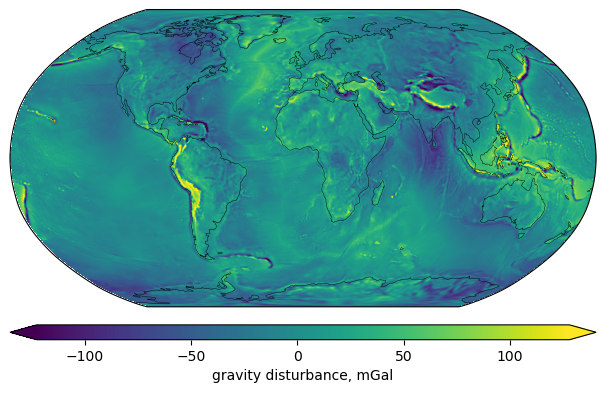

In [12]:
GGM_gd_fig, GGM_gd_ax = GGM_grid_gd.plot(projection=fig_projection,
                                         colorbar="bottom", cmap='viridis',
                                         cmap_limits=[
                                             np.quantile(GGM_grid_gd.data,fig_cmap_quantiles[0]),
                                             np.quantile(GGM_grid_gd.data,fig_cmap_quantiles[1])
                                         ], cb_triangles="both",
                                         cb_label = 'gravity disturbance, mGal',
                                         show=False)
GGM_gd_ax.coastlines(resolution='110m', color='black', linewidth=0.3)
GGM_gd_fig.set_dpi(fig_dpi)
GGM_gd_fig.show()

### Terrain effect
For the sake of clarity, only the radial component of the terrain effect is plotted.
See the following cell for the three components and a (misleading) computed magnitude.

<ipython-input-13-f0bcfc15e2bc>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  GTM_rad_fig.show()


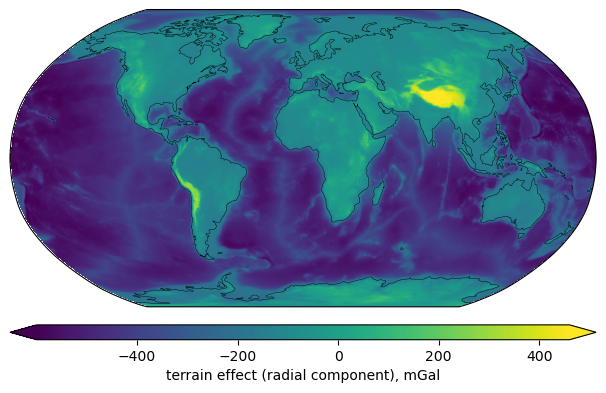

In [13]:
GTM_rad_fig, GTM_rad_ax = GTM_grid_rad.plot(projection=fig_projection,
                                            colorbar="bottom", cmap='viridis',
                                            cmap_limits=[
                                                np.quantile(GTM_grid_rad.data,fig_cmap_quantiles[0]),
                                                np.quantile(GTM_grid_rad.data,fig_cmap_quantiles[1])
                                            ], cb_triangles="both",
                                            cb_label = 'terrain effect (radial component), mGal',
                                            show=False)
GTM_rad_ax.coastlines(resolution='110m', color='black', linewidth=0.3)
GTM_rad_fig.set_dpi(fig_dpi)
GTM_rad_fig.show()

### Terrain effect: all components and misleading magnitude
$g_r$, $g_\theta$, and $g_\phi$, the three spherical components of the attraction of the terrain correction (here $g_r$ is expressed downward positive).

The all-positive magnitude (lower right panel) mixes oceans and high topography.

<ipython-input-14-e6d3588bc9aa>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  GTM_full_fig.show()


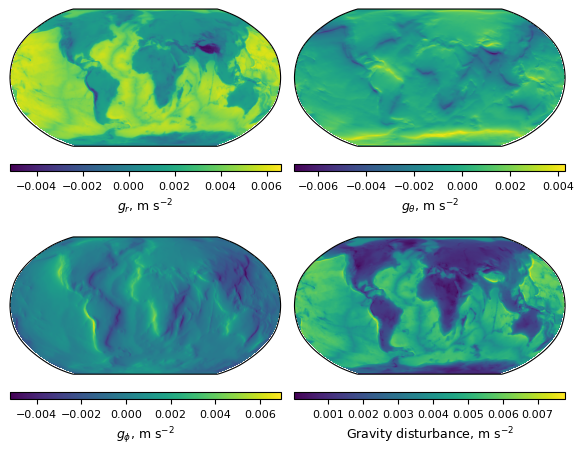

In [14]:
GTM_full_fig, GTM_full_ax = GTM_grid.plot(projection=fig_projection,
                                          colorbar="bottom", cmap='viridis',
                                          show=False)
GTM_full_fig.set_dpi(fig_dpi)
GTM_full_fig.show()

### Topography-reduced gravity disturbance

<ipython-input-15-8a489a265014>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  BG_fig.show()


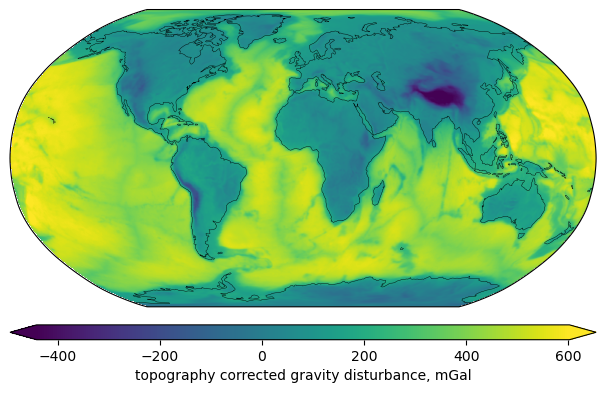

In [15]:
BG_fig, BG_ax = Tbg_GravGrid_total.plot(projection=fig_projection,
                                        colorbar="bottom", cmap='viridis',
                                        cmap_limits=[
                                            np.quantile(Tbg_GravGrid_total.data,fig_cmap_quantiles[0]),
                                            np.quantile(Tbg_GravGrid_total.data,fig_cmap_quantiles[1])
                                        ], cb_triangles="both",
                                        cb_label = 'topography corrected gravity disturbance, mGal',
                                        show=False)
BG_ax.coastlines(resolution='110m', color='black', linewidth=0.3)
BG_fig.set_dpi(fig_dpi)
BG_fig.show()

### Marussi tensor of the topography-reduced disturbing potential
Since we are here, why not? Using the `tensor()` method of `pyshtools.SHGravCoeffs`.

Note: there might be issues with non-removed normal gravity and centrifugal potential.

In [16]:
Tbg_tensor = Tbg_GravCoeffs.tensor(a=obs_a, f=pyshtools.constant.f_wgs84.value, degree0=False)

<ipython-input-17-51c10cd433bb>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tensor_fig.show()


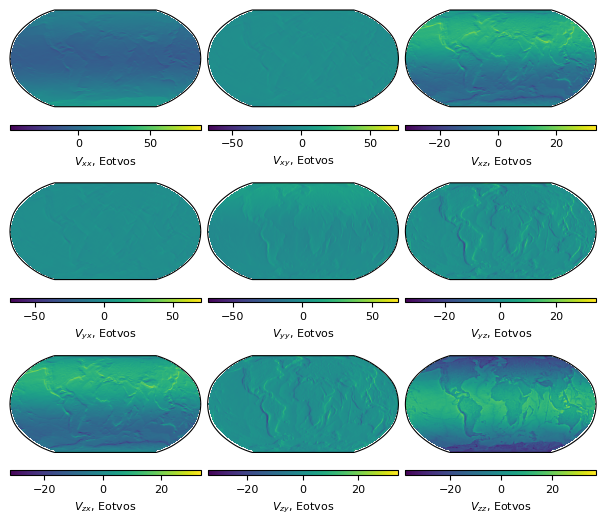

In [17]:
tensor_fig, tensor_ax = Tbg_tensor.plot(projection=fig_projection,
                                        colorbar="bottom", cmap='viridis',
                                        show=False)
tensor_fig.set_dpi(fig_dpi)
tensor_fig.show()

#### Plot the three invariants of the tensor and the derived quantity I (Pedersen and Rasmussen, 1990)

<ipython-input-18-ac139caa1476>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tensor_i_fig.show()


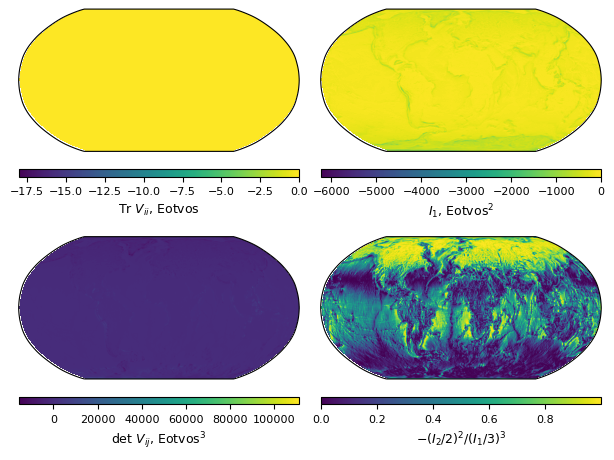

In [18]:
tensor_i_fig, tensor_i_ax = Tbg_tensor.plot_invar(projection=fig_projection,
                                                  colorbar="bottom", cmap='viridis',
                                                  show=False)
tensor_i_fig.set_dpi(fig_dpi)
tensor_i_fig.show()